In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_JSON_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/label/train/'
VALID_JSON_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/label/val/'

TRAIN_IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/img/train/'
VALID_IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/img/val/'

TRAIN_SEGMENT_PATH = '/content/drive/MyDrive/Colab Notebooks/myData/segmentation/train/'
VALID_SEGMENT_PATH = '/content/drive/MyDrive/Colab Notebooks/myData/segmentation/val/'

CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/myData/'

PREPROC_TRAIN_IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/myData/preprocessed/train/'
PREPROC_VALID_IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/myData/preprocessed/val/'

In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets
import torchvision.transforms as tt
import torchvision
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [ ]:
class CropAroundFace:
    def __init__(self, coordinates_csv):
        if coordinates_csv is not None:
            self.coordinates = self.load_coordinates(coordinates_csv)
        else:
            self.coordinates = None

    def load_coordinates(self, csv_file):
        df = pd.read_csv(csv_file)
        return df

    def __call__(self, img, image_path):
        #img=exif_delete(image_path)
        if self.coordinates is None:
            return img
        image_id = os.path.basename(image_path)  # 이미지 파일명 추출
        coord = self.coordinates[self.coordinates['filename'] == image_id]

        if coord.empty:
            print(f"image {image_id} not found.")
            return img  # 이미지를 그대로 반환

        minX = coord.iloc[0]['minX']
        maxX = coord.iloc[0]['maxX']
        minY = coord.iloc[0]['minY']
        maxY = coord.iloc[0]['maxY']

        img = img.crop((minX, minY, maxX, maxY))
        return img

# 커스텀 ImageFolder 정의
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, cropper=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.cropper = cropper

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.cropper is not None:
            sample = self.cropper(sample, path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

In [ ]:
random_seed = 1523
torch.manual_seed(random_seed)

#하이퍼 파라미터
BATCH_SIZE = 32
image_size= 224
df_train = CSV_PATH + 'train_ver3.csv'
df_valid = CSV_PATH + 'valid_ver3.csv'
crop_face_train = CropAroundFace(df_train)
crop_face_valid = CropAroundFace(df_valid)
no_crop = CropAroundFace(None)
origin_transforms = tt.Compose([
                               tt.Grayscale(num_output_channels=3),
                               tt.RandomEqualize(p=1.0),
                               tt.Resize((image_size,image_size)),
                               #tt.RandomHorizontalFlip(p=0.3),
                               #tt.RandomRotation((-10,10)),
                               #tt.ColorJitter(brightness=(0.5, 0.9), contrast=(0.4, 0.8), saturation=(0.7, 0.9)),
                               #tt.RandomEqualize(p=1.0),
                               tt.ToTensor(),
                               #tt.Normalize([0.5630258, 0.44020364, 0.38816002], [0.24872069, 0.20780964, 0.18916753],inplace=True)
                               #tt.Normalize([0.49906865, 0.49850065, 0.49802032], [0.28936213, 0.2896722, 0.2898643],inplace=True)
                               #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                               ])
at_train_transforms1 = tt.Compose([
                              tt.Grayscale(num_output_channels=3),
                              tt.RandomEqualize(p=1.0),
                              tt.Resize((image_size,image_size)),
                              tt.RandomHorizontalFlip(p=1.0),
                              #tt.RandomRotation((-12,12)),
                              tt.ToTensor(),
                              #tt.Normalize([0.5630291, 0.4402049, 0.3881598], [0.24872099, 0.2078098, 0.18916771],inplace=True)
                              #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])
at_train_transforms2 = tt.Compose([
                              tt.Grayscale(num_output_channels=3),
                              tt.RandomEqualize(p=1.0),
                              tt.Resize((image_size,image_size)),
                              #tt.RandomHorizontalFlip(p=0.5),
                              tt.RandomRotation((-20,20)),
                              #tt.ColorJitter(brightness=(0.5, 0.8), contrast=(0.4, 0.8), saturation=(0.7, 0.9)),
                              tt.ToTensor(),
                              #tt.Normalize([0.5412756, 0.42083004, 0.3695388], [0.27376023, 0.22556551, 0.20402727],inplace=True)
                              #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])
at_train_transforms3 = tt.Compose([
                              tt.Grayscale(num_output_channels=3),
                              tt.RandomEqualize(p=1.0),
                              tt.Resize((image_size,image_size)),
                              #tt.RandomHorizontalFlip(p=0.5),
                              #tt.RandomRotation((-12,12)),
                              tt.ColorJitter(brightness=(0.6,0.9)),
                              tt.ToTensor(),
                              #tt.Normalize([0.5843284, 0.4594015, 0.40504286], [0.26762614, 0.2274408, 0.2068571],inplace=True)
                              #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])
at_train_transforms4 = tt.Compose([
                              tt.Grayscale(num_output_channels=3),
                              tt.RandomEqualize(p=1.0),
                              tt.Resize((image_size,image_size)),
                              tt.GaussianBlur(kernel_size=(19, 19), sigma=(1.0, 2.2)),
                              #tt.RandomHorizontalFlip(p=0.5),
                              #tt.RandomRotation((-12,12)),
                              #tt.ColorJitter(brightness=(0.5, 0.8), contrast=(0.4, 0.8), saturation=(0.7, 0.9)),
                              tt.ToTensor(),
                              #tt.Normalize([0.56310797, 0.44026062, 0.38820478], [0.2432182, 0.20207751, 0.1836703],inplace=True)
                              #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])
at_train_transforms5 = tt.Compose([
                              tt.Grayscale(num_output_channels=3),
                              tt.RandomEqualize(p=1.0),
                              tt.Resize((image_size,image_size)),
                              tt.RandomAffine(degrees =0,translate=(0.2, 0.2)),
                              #tt.RandomHorizontalFlip(p=0.5),
                              #tt.RandomRotation((-12,12)),
                              #tt.ColorJitter(brightness=(0.5, 0.8), contrast=(0.4, 0.8), saturation=(0.7, 0.9)),
                              tt.ToTensor(),
                              #tt.Normalize([0.47796503, 0.3703487, 0.3250615], [0.3130017, 0.2526793, 0.22655305],inplace=True)
                              #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])
at_train_transforms6 = tt.Compose([
                              tt.Grayscale(num_output_channels=3),
                              tt.RandomEqualize(p=1.0),
                              tt.Resize((image_size,image_size)),
                              tt.RandomAffine(degrees=0,scale=(0.6, 0.8),translate=(0.2, 0.2)),
                              #tt.RandomHorizontalFlip(p=0.5),
                              #tt.RandomRotation((-12,12)),
                              #tt.ColorJitter(brightness=(0.5, 0.8), contrast=(0.4, 0.8), saturation=(0.7, 0.9)),
                              tt.ToTensor(),
                              #tt.Normalize([0.27812216, 0.21746288, 0.1917359], [0.33143228, 0.26421398, 0.23528142],inplace=True)
                              #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])

valid_transforms = tt.Compose([
                               tt.Grayscale(num_output_channels=3),
                               tt.RandomEqualize(p=1.0),
                               tt.Resize((image_size,image_size)),
                               tt.ToTensor(),
                              # tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],inplace=True)
                               #tt.Normalize([0.5630258, 0.44020364, 0.38816002], [0.24872069, 0.20780964, 0.18916753],inplace=True)
                               #tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],inplace=True)
                              ])


In [ ]:
#주소 알아서 수정하기

classes_train = os.listdir(TRAIN_IMG_PATH)

origin_dataset = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=origin_transforms, cropper=no_crop)

train_dataset_flip = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=at_train_transforms1, cropper=no_crop)

train_dataset_rotate = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=at_train_transforms2, cropper=no_crop)

train_dataset_bright = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=at_train_transforms3, cropper=no_crop)

train_dataset_noise = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=at_train_transforms4, cropper=no_crop)

train_dataset_shift = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=at_train_transforms5, cropper=no_crop)

train_dataset_zoomout = CustomImageFolder(PREPROC_TRAIN_IMG_PATH + 'crop/', transform=at_train_transforms6, cropper=no_crop)

classes_valid = os.listdir(VALID_IMG_PATH)
valid_dataset = CustomImageFolder(PREPROC_VALID_IMG_PATH + 'crop/', valid_transforms, cropper=no_crop)

train_dataset = ConcatDataset([origin_dataset, train_dataset_flip, train_dataset_rotate, train_dataset_bright, train_dataset_noise, train_dataset_shift, train_dataset_zoomout])

train_dataloader = DataLoader(train_dataset, BATCH_SIZE,
                              shuffle=True, num_workers=8, pin_memory=True)

valid_dataloader = DataLoader(valid_dataset, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
temp1_dataloader = DataLoader(origin_dataset, BATCH_SIZE,
                              shuffle=False, num_workers=8, pin_memory=True)

temp2_dataloader = DataLoader(train_dataset_flip, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

temp3_dataloader = DataLoader(train_dataset_rotate, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

temp4_dataloader = DataLoader(train_dataset_bright, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

temp5_dataloader = DataLoader(train_dataset_noise, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

temp6_dataloader = DataLoader(train_dataset_shift, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

temp7_dataloader = DataLoader(train_dataset_zoomout, BATCH_SIZE,
                              num_workers=8, pin_memory=True, shuffle=False)

In [ ]:
len(origin_dataset)

5992

In [ ]:
# origin_dataset[0]

In [ ]:
# imgs = [item for item, labels in origin_dataset]

In [ ]:
# len(imgs)

In [ ]:
# #  imgs를 하나로 합침
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
# imgs = [item for item, labels in train_dataset_flip]

In [ ]:
#  #imgs를 하나로 합침
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
# imgs = [item for item, labels in train_dataset_rotate]

In [ ]:
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
# imgs = [item for item, labels in train_dataset_bright]

In [ ]:
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
# imgs = [item for item, labels in train_dataset_noise]

In [ ]:
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
# imgs = [item for item, labels in train_dataset_shift]

In [ ]:
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
# imgs = [item for item, labels in train_dataset_zoomout]

In [ ]:
# imgs = torch.stack(imgs, dim=0).numpy()

In [ ]:
#  # rgb 각 평균
# mean_r = imgs[:,0,:,:].mean()
# mean_g = imgs[:,1,:,:].mean()
# mean_b = imgs[:,2,:,:].mean()
# print(mean_r, mean_g, mean_b)

#  # rgb 각 표준편차
# std_r = imgs[:,0,:,:].std()
# std_g = imgs[:,1,:,:].std()
# std_b = imgs[:,2,:,:].std()
# print(std_r, std_g, std_b)

In [ ]:
original_images, ori_labels = next(iter(temp1_dataloader))

In [ ]:
# original_images.shape

In [ ]:
transform_images, trans_labels = next(iter(temp2_dataloader))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


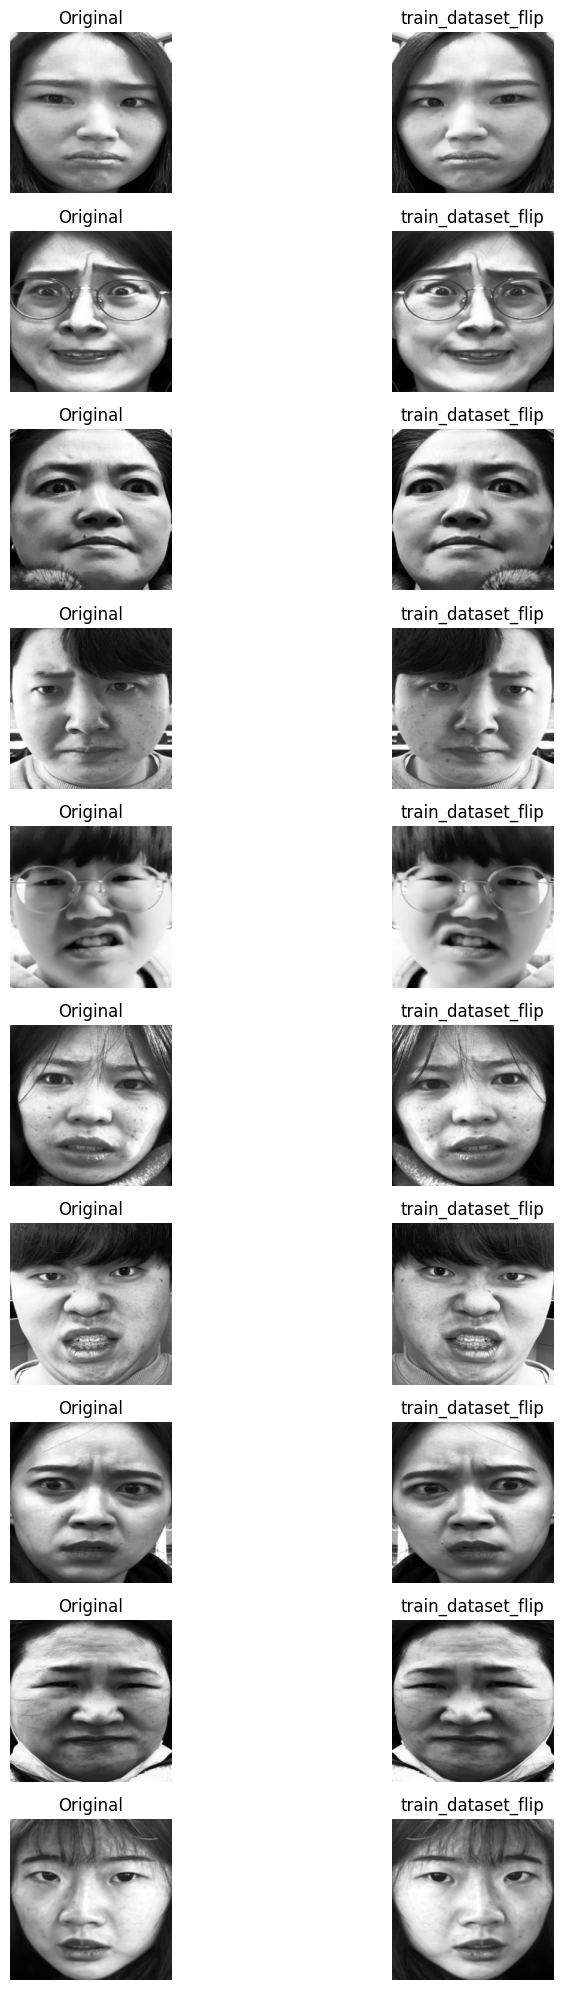

In [ ]:
fig, axes = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
print(ori_labels)
print(trans_labels)
print(len(original_images))
for idx in range(10):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('train_dataset_flip')
fig.tight_layout()
plt.show()

In [ ]:
transform_images, trans_labels = next(iter(temp3_dataloader))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


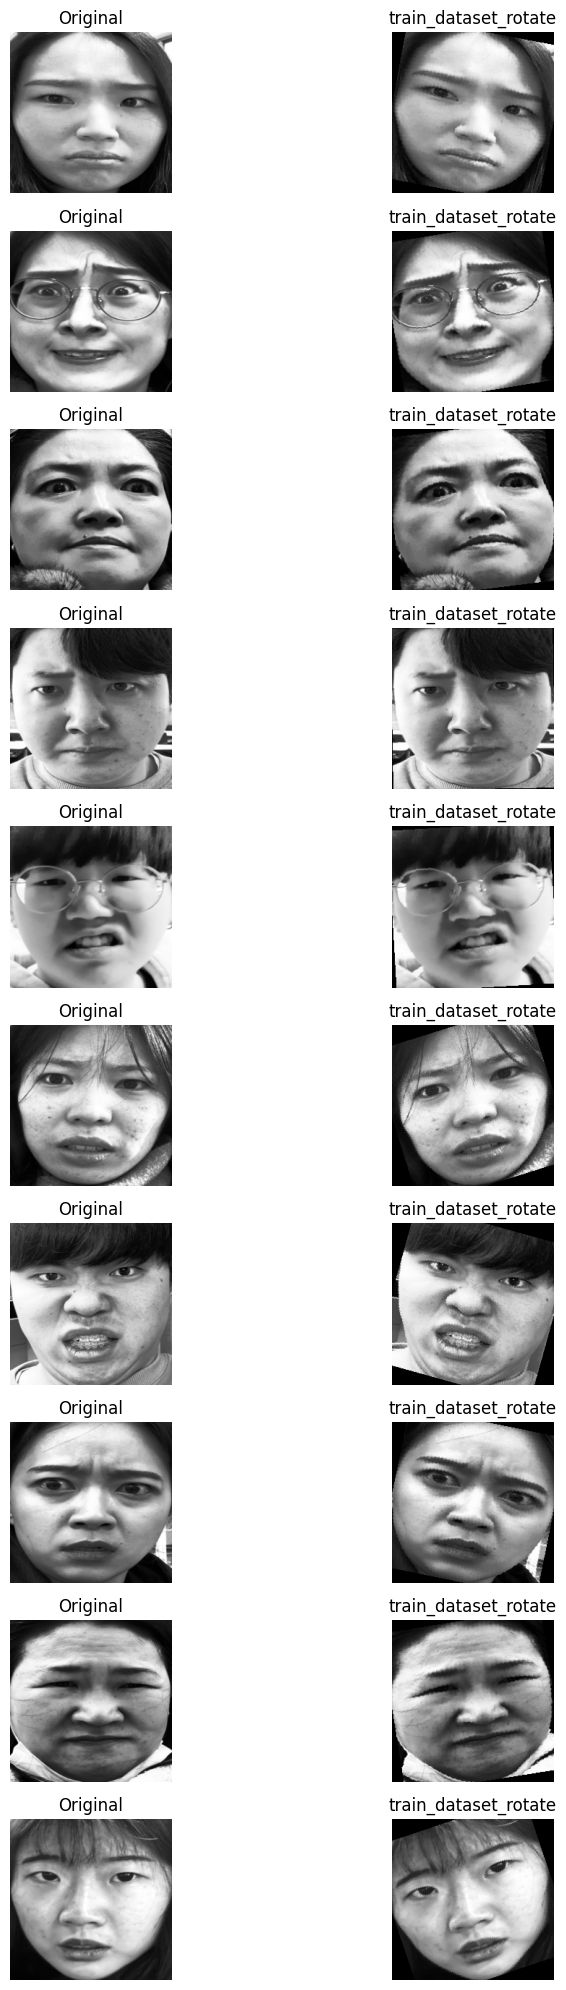

In [ ]:
fig, axes = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
print(ori_labels)
print(trans_labels)
print(len(original_images))
for idx in range(10):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('train_dataset_rotate')
fig.tight_layout()
plt.show()

In [ ]:
transform_images, trans_labels = next(iter(temp4_dataloader))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


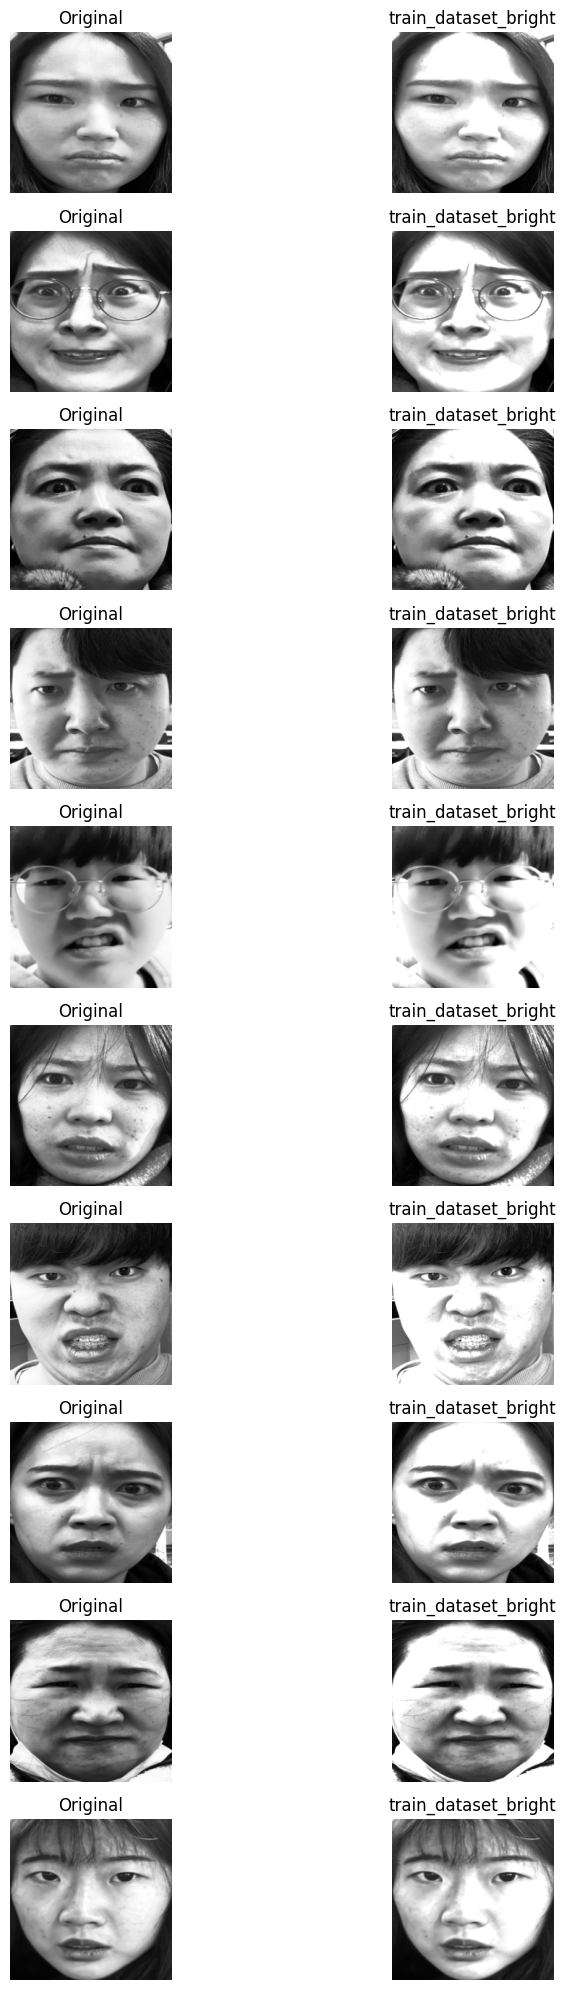

In [ ]:
fig, axes = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
print(ori_labels)
print(trans_labels)
print(len(original_images))
for idx in range(10):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('train_dataset_bright')
fig.tight_layout()
plt.show()

In [ ]:
transform_images, trans_labels = next(iter(temp5_dataloader))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


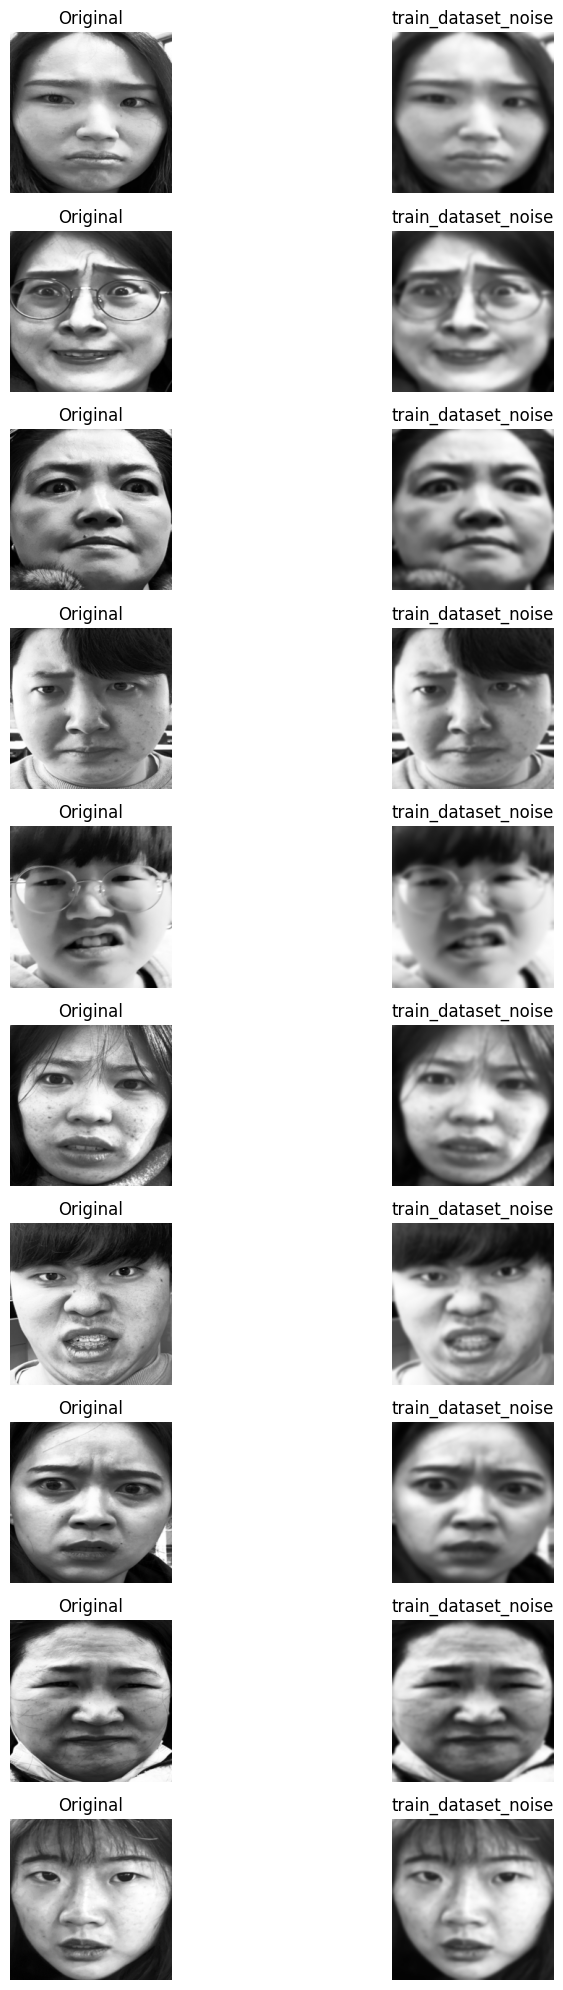

In [ ]:
fig, axes = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
print(ori_labels)
print(trans_labels)
print(len(original_images))
for idx in range(10):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('train_dataset_noise')
fig.tight_layout()
plt.show()

In [ ]:
transform_images, trans_labels = next(iter(temp6_dataloader))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


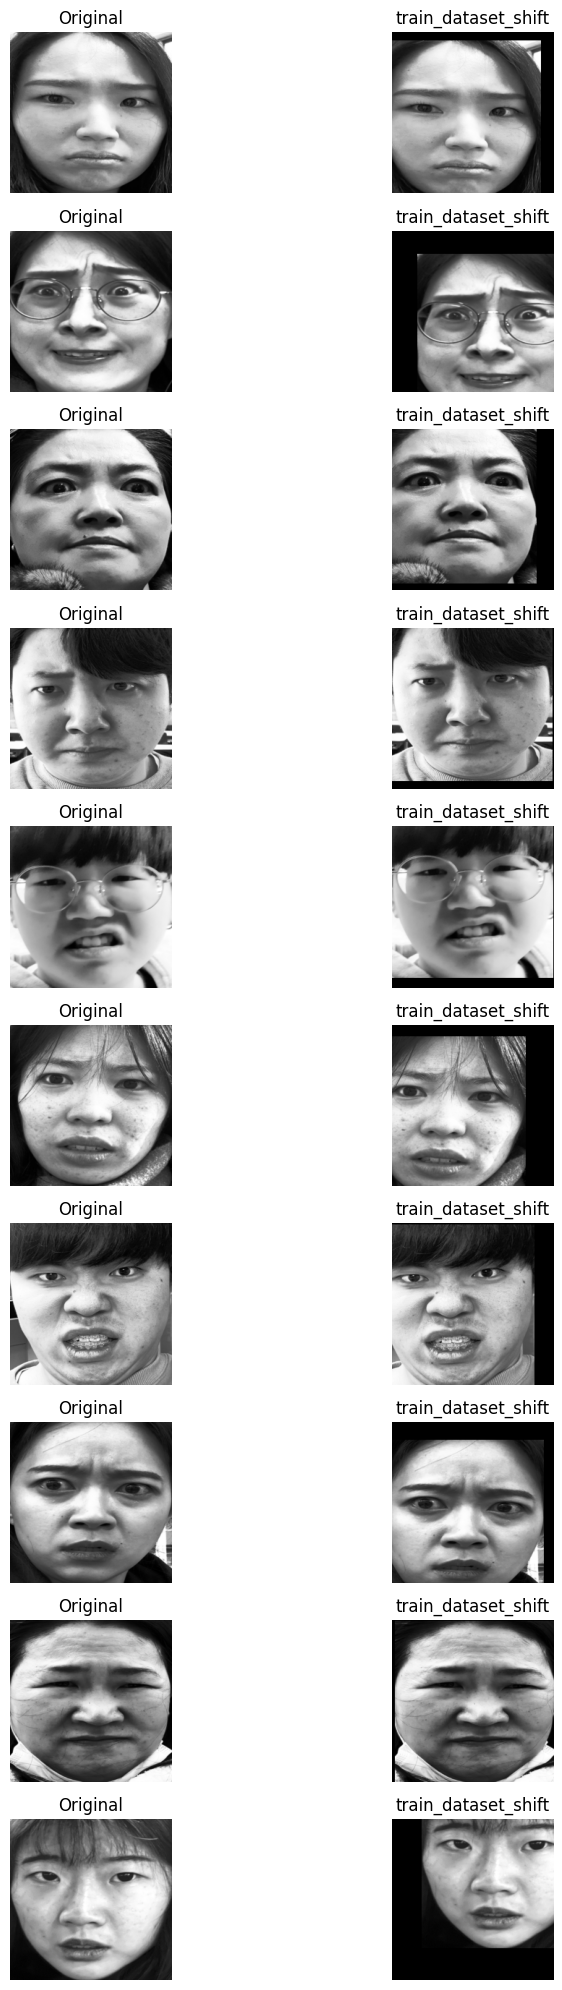

In [ ]:
fig, axes = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
print(ori_labels)
print(trans_labels)
print(len(original_images))
for idx in range(10):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('train_dataset_shift')
fig.tight_layout()
plt.show()

In [ ]:
transform_images, trans_labels = next(iter(temp7_dataloader))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


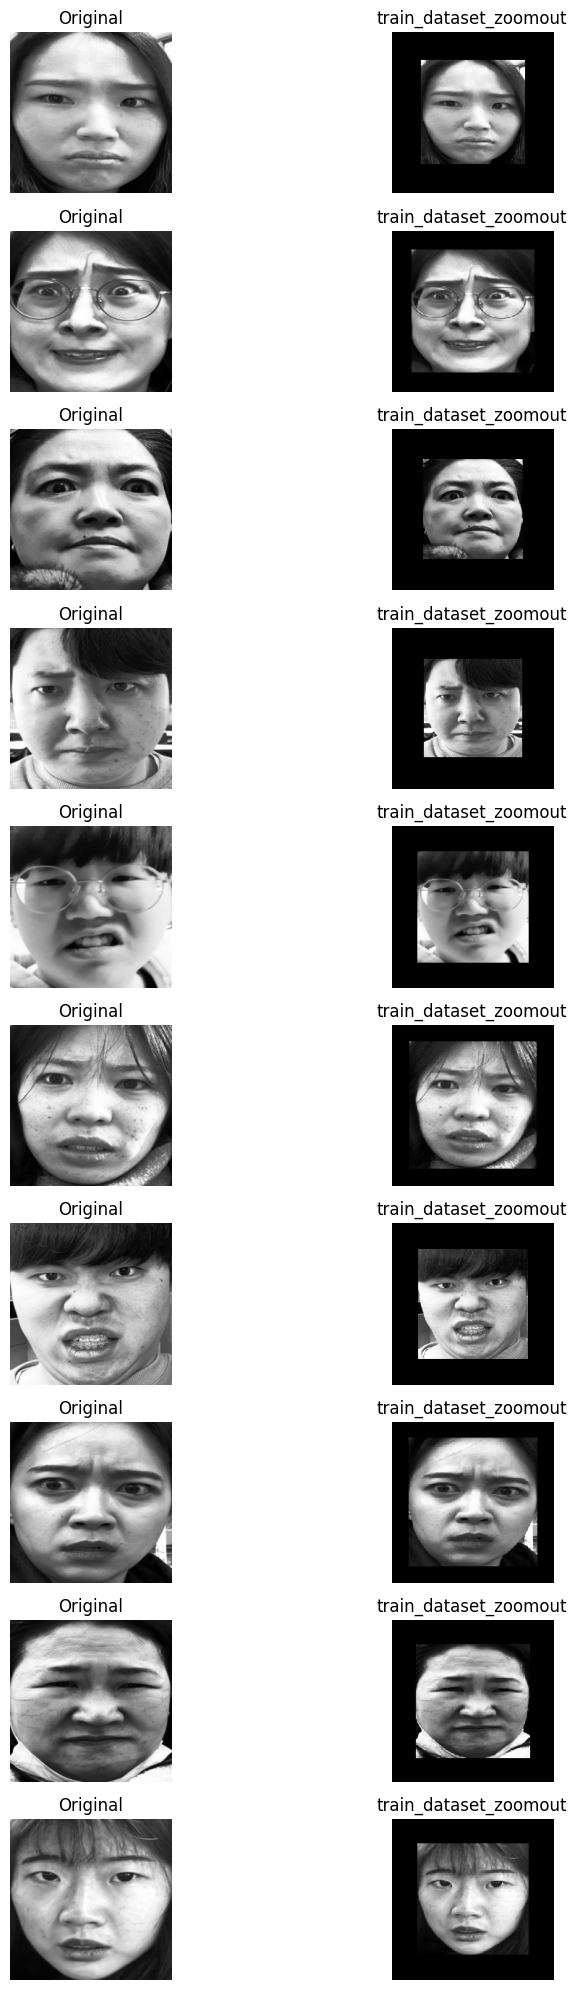

In [ ]:
fig, axes = plt.subplots(10, 2)
fig.set_size_inches(10, 20)
print(ori_labels)
print(trans_labels)
print(len(original_images))
for idx in range(10):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('train_dataset_zoomout')
fig.tight_layout()
plt.show()